# ДЗ 6. Классификация текста. Анализ тональности текста

Взять ноутбук colab_text_classification_part1.ipynb который разбирали на занятии (лежит в архиве lection6_materials_actual.zip
) и добавить пункты которые мы пропустили.  

1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново  
2. Проверьте повысилось ли качество на стандартных подходах при лемматизации/и без неё  
3. Удалите/(замените на тег) из текстов сущности(имена, локации, что-то ещё). Запустите классификатор и модельки на сеточках  
4. Сделайте выводы  

In [4]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
     |████████████████████████████████| 12.0 MB 10.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Тут придется авторизировать запрос к гугл драйву, извините.

In [6]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

## Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [7]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [8]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [10]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'excellent',  'perfect', 'ideal', 'amazing', 'beautiful', 'genuine', 'delightful', 'pleasant', 'thank', 'joy', 'recommend', 'incredible', 'fantastic', 'popular', 'enjoyable', 'well', 'ideal', 'amazing', 'surprised' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap', 'bad', 'moron',  'suck',  'shit', 'boring', 'fail', 'harmful', 'nonsense', 'poor', 'repellant', 'terrible', 'threatening', 'zero', 'worst', 'awful', 'crap', 'ridiculous', 'sake', 'meaningless', 'WEAK', 'horrible' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 75.31%


/usr/local/lib/python3.7/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'tuple'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>

**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [11]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [12]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Посмотрим на слова, попавшие в словарь:

In [15]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

Попробуем кого-нибудь таки сконвертировать

In [16]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [18]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
             

In [19]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.50%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [20]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight?,Feature
+1.855,refreshing
+1.760,wonderfully
+1.689,funniest
+1.647,surprisingly
+1.626,rare
+1.432,superb
+1.401,excellent
+1.365,incredible
+1.351,perfect
+1.302,delightful


Посмотрим на конкретные примеры его работы:

In [21]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [22]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [23]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df = 0.01, max_df = 0.9)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.46%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), stop_words='english', max_features=20000, analyzer='char', min_df = 0.01, max_df = 0.9)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.29%


In [30]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [31]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [32]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls B ORG
, , O 
despite despite O 
its -PRON- O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it -PRON- O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithfu

Весь этот процесс очень долгий, поэтому я предподсчитал всё.

In [33]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)
    
with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [34]:
class TextPreprocessor:
    def __init__(self, file, main_inf, csv_path = True):
        '''
        file - file path if csv_path true else pandas file
        main_inf - base column name
        '''
        self.start_name = main_inf
        self.last_col = None
        if csv_path:
            self.data = pd.read_csv(file)
        else:
            self.data = file.copy()
        self.data_work = self.data.copy()

    def get_data(self):
        return self.data.copy()

    def get_data_work(self):
        return self.data_work.copy()

    def get_start_name(self):
        return self.start_name

    def clean_users(self):
        regex = re.compile("@[\w]*")

        def without_mention(text, regex=regex):
            return re.sub(regex, ' ', text)
        
        work_col = self.start_name+'_wo_mention'

        self.data_work[work_col] = None
        for i in range(0, self.data_work.shape[0]):
            self.data_work[work_col][i] = without_mention(self.data_work[self.start_name][i]).lower()

        self.last_col = work_col

    def change_words_by_dict(self, dict_to_check, dict_name):
        if self.last_col:
            work_col = self.start_name+'_wo_dist_'+dict_name
            where_col = self.last_col
        else:
            work_col = self.start_name+'_wo_dist_'+dict_name
            where_col = self.start_name
        
        self.data_work[work_col] = None

        for i in range(0, self.data_work.shape[0]):
            text = self.data_work[where_col][i] 
            for word in text.split():
                if word in dict_to_check:
                    pos = text.find(word)
                    text = text[:pos] + dict_to_check[word] +' ' + text[pos+len(word)+1:]
            self.data_work[work_col][i] = text
        
        self.last_col = work_col
    
    def delete_punct(self): 
        regex2 = re.compile( r'[^\w\s]')

        def wo_punct(text, regex=regex2):
            return re.sub(regex, ' ', text)

        if self.last_col:
            work_col = self.start_name+'_wo_dist_punct'
            where_col = self.last_col
        else:
            work_col = self.start_name+'_wo_dist_punct'
            where_col = self.start_name

        self.data_work[work_col] = None
        for i in range(0, self.data_work.shape[0]):
            self.data_work[work_col][i] = wo_punct(self.data_work[where_col][i]).lower()

        self.last_col = work_col


    def delete_spec(self):
        regex3 = re.compile( r'[^a-zA-Z0-9]')

        def wo_spec(text, regex=regex3):
            return re.sub(regex, ' ', text)

        if self.last_col:
            work_col = self.start_name+'_wo_dist_spec'
            where_col = self.last_col
        else:
            work_col = self.start_name+'_wo_dist_spec'
            where_col = self.start_name

        self.data_work[work_col] = None
        for i in range(0, self.data_work.shape[0]):
            self.data_work[work_col][i] = wo_spec(self.data_work[where_col][i]).lower()

        self.last_col = work_col       
        

    def delete_numb(self): 
        regex4 = re.compile( r'[^a-zA-Z]')

        def wo_numb(text, regex=regex4):
            return re.sub(regex, ' ', text)

        if self.last_col:
            work_col = self.start_name+'_wo_dist_numb'
            where_col = self.last_col
        else:
            work_col = self.start_name+'_wo_dist_numb'
            where_col = self.start_name

        self.data_work[work_col] = None
        for i in range(0, self.data_work.shape[0]):
            self.data_work[work_col][i] = wo_numb(self.data_work[where_col][i]).lower()

        self.last_col = work_col

    def delete_short_words(self, length=1):

        if self.last_col:
            work_col = self.start_name+'_wo_short_words'
            where_col = self.last_col
        else:
            work_col = self.start_name+'_wo_short_words'
            where_col = self.start_name

        self.data_work[work_col] = None
        for i in range(0, self.data_work.shape[0]):
            text = self.data_work[where_col][i] 
            self.data_work[work_col][i] = ' '.join([w for w in text.split() if len(w)>length])
        
        self.last_col = work_col

    def do_tokinze(self):

        if self.last_col:
            work_col = self.start_name+'_tokens'
            where_col = self.last_col
        else:
            work_col = self.start_name+'_tokens'
            where_col = self.start_name

        self.data_work[work_col] = None
        for i in range(0, self.data_work.shape[0]):
            text = self.data_work[where_col][i] 
            self.data_work[work_col][i] = tknz.word_tokenize(text)

        self.last_col = work_col

    
    def wo_stopwords(self):

        if self.last_col:
            work_col = self.start_name+'_tokens_wo_stopwords'
            where_col = self.last_col
        else:
            work_col = self.start_name+'_tokens_wo_stopwords'
            where_col = self.start_name

        stop_words = set(stopwords.words("english"))

        self.data_work[work_col] = None
        for i in range(0, self.data_work.shape[0]):
            li = self.data_work[where_col][i] 
            self.data_work[work_col][i] = [word for word in li if not word in stop_words]

        self.last_col = work_col


    def stemmer(self):
        if self.last_col:
            work_col = self.start_name+'_stemm'
            where_col = self.last_col
        else:
            work_col = self.start_name+'_stemm'
            where_col = self.start_name

        stemmer = PorterStemmer()
        self.data_work[work_col] = None
        
        for i in range(0, self.data_work.shape[0]):
            li = self.data_work[where_col][i]
            res = [] 
            for word in li:
                res.append(stemmer.stem(word))
            self.data_work[work_col][i] = res
      
        self.last_col = work_col

    def lemmer(self):
        if self.last_col:
            work_col = self.start_name+'_lemm'
            where_col = self.last_col
        else:
            work_col = self.start_name+'_lemm'
            where_col = self.start_name

        lemmatizer = WordNetLemmatizer()
        self.data_work[work_col] = None

        for i in range(0, self.data_work.shape[0]):
            li = self.data_work[where_col][i]
            res = [] 
            for word in li:
                res.append(lemmatizer.lemmatize(word))
            self.data_work[work_col][i] = ' '.join(res)
        
        self.last_col = work_col
    
    def add_final_inf_to_data(self):
        self.data['Preproc_text'] = self.data_work[self.last_col]

    def full_preprocessor(self):
        print('stage 1: @')
        self.clean_users()
        print('stage 1: apostr')
        #self.change_words_by_dict(apostrophe_dict, 'apostr')
        print('stage 2: short')
        #self.change_words_by_dict(short_word_dict, 'shw')
        print('stage 3: emotr')
        #self.change_words_by_dict(emoticon_dict, 'emot')
        print('stage 4: punctr')
        self.delete_punct()
        print('stage 5: spec')
        self.delete_spec()
        print('stage 6: numb')
        self.delete_numb()
        print('stage 7: short2')
        self.delete_short_words()
        print('stage 8: token')
        self.do_tokinze()
        print('stage 9: stopwords')
        self.wo_stopwords()
        print('stage 10: stem')
        self.stemmer()
        print('stage 11: lemm')
        self.lemmer()
        self.add_final_inf_to_data()

In [35]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
from nltk.tokenize import word_tokenize
from nltk import tokenize as tknz
from nltk.stem import WordNetLemmatizer

In [36]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
TP = TextPreprocessor(train_df,'review' , csv_path = False)
TP.full_preprocessor()

stage 1: @


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 1: apostr
stage 2: short
stage 3: emotr
stage 4: punctr


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 5: spec


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 6: numb


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 7: short2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 8: token


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 9: stopwords


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 10: stem


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 11: lemm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
TP.add_final_inf_to_data()
TP.get_data_work().head(2)

,is_positive,review,review_wo_mention,review_wo_dist_punct,review_wo_dist_spec,review_wo_dist_numb,review_wo_short_words,review_tokens,review_tokens_wo_stopwords,review_stemm,review_lemm
0,0,"Dreamgirls, despite its fistful of Tony wins i...","dreamgirls, despite its fistful of tony wins i...",dreamgirls despite its fistful of tony wins i...,dreamgirls despite its fistful of tony wins i...,dreamgirls despite its fistful of tony wins i...,dreamgirls despite its fistful of tony wins in...,"[dreamgirls, despite, its, fistful, of, tony, ...","[dreamgirls, despite, fistful, tony, wins, inc...","[dreamgirl, despit, fist, toni, win, incred, w...",dreamgirl despit fist toni win incred weak yea...
1,0,This show comes up with interesting locations ...,this show comes up with interesting locations ...,this show comes up with interesting locations ...,this show comes up with interesting locations ...,this show comes up with interesting locations ...,this show comes up with interesting locations ...,"[this, show, comes, up, with, interesting, loc...","[show, comes, interesting, locations, fast, tr...","[show, come, interest, locat, fast, travel, ch...",show come interest locat fast travel channel b...


In [39]:
train_df['res_lem_stem'] = TP.get_data_work()['review_lemm']

In [40]:
TP = TextPreprocessor(test_df,'review' , csv_path = False)
TP.full_preprocessor()

stage 1: @


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 1: apostr
stage 2: short
stage 3: emotr
stage 4: punctr


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 5: spec


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 6: numb


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 7: short2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 8: token


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 9: stopwords


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 10: stem


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stage 11: lemm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
TP.add_final_inf_to_data()

In [42]:
test_df['res_lem_stem'] = TP.get_data_work()['review_lemm']

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.01, max_df = 0.9)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['res_lem_stem'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 80.18%


In [44]:
train_df['res_stem_list'] = TP.get_data_work()['review_stemm']

In [45]:
train_df['res_stem'] = None
for i in range(0, train_df.shape[0]):
    li = train_df['res_stem_list'][i]
    train_df['res_stem'][i] = ' '.join(li)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


**Задание** Попробуйте вместо лемм классифицировать основы.

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['res_stem'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 51.84%


### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [47]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [48]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

In [49]:
cur_res = test_df.is_positive.to_numpy()

In [50]:
to_compare = []
for i in range(len(cur_res)):
    to_compare.append([cur_res[i]])

<a list of 231 Patch objects>

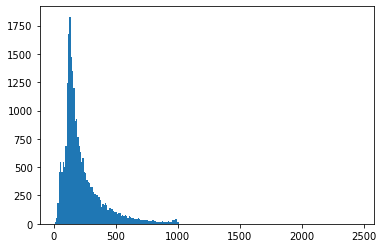

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [52]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [53]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [54]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [55]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [56]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1714112   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 13s 49ms/step - loss: 0.6454 - accuracy: 0.6761 - val_loss: 0.5367 - val_accuracy: 0.8298
Epoch 2/10
196/196 [==============================] - 10s 49ms/step - loss: 0.3714 - accuracy: 0.8701 - val_loss: 0.3114 - val_accuracy: 0.8714
Epoch 3/10
196/196 [==============================] - 10s 49ms/step - loss: 0.2085 - accuracy: 0.9221 - val_loss: 0.2894 - val_accuracy: 0.8790
Epoch 4/10
196/196 [==============================] - 9s 49ms/step - loss: 0.1260 - accuracy: 0.9583 - val_loss: 0.3036 - val_accuracy: 0.8776
Epoch 5/10
196/196 [==============================] - 9s 49ms/step - loss: 0.0667 - accuracy: 0.9826 - val_loss: 0.3400 - val_accuracy: 0.8734
Epoch 6/10
196/196 [==============================] - 10s 50ms/step - loss: 0.0301 - accuracy: 0.9945 - val_loss: 0.3833 - val_accuracy: 0.8718
Epoch 7/10
196/196 [==============================] - 10s 51ms/step - loss: 0.0130 - accuracy: 0.9985 - val_loss: 0.4302 - val_accuracy: 0

**Задание** Подсчитайте качество модели на тесте

In [58]:
test = model.predict(X_test)

In [59]:
test

array([[0.00114741],
       [0.99999976],
       [0.14944544],
       ...,
       [0.9960698 ],
       [0.99995387],
       [0.8969568 ]], dtype=float32)

In [61]:
acc = 0
for i in range(len(test)):
    if (test[i][0] > 0.5 and to_compare[i][0] == 1) or (test[i][0] < 0.5 and to_compare[i][0] == 0):
        acc += 1
acc/len(test)

0.86848